<h1 align="center">An Analysis of Worldwide Air Quality</h1>

<h2 align="center"> By Julia Kaplan and Analese Lutz</h2>

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import folium
import functions
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.1 ms (started: 2021-12-06 15:11:40 -05:00)


## Problem Statement

Background Information: The pollutants PM25, PM10, and ozone (o3) all come from emissions from gasolines, oil diesel fuel, power plants, or wood. 

Our goal of the project was the answer the following question: 

- Is there a correlation between population size and air quality?
- Additionally, is there a correlation between elevation and air quality?
- Finally, how does each of the three pollutants (PM25, PM10, and O3) correlate with air quality?

## Data

To answer our questions, we used data from two APIs: Air Quality Programmatic API and the Spott REST API. 

The Air Quality Programmatic API provides city level data about air quality index and individual pollutants (PM2.5, PM10, Ozone (O3)). The API also provides data on city latitude and longitude. 

The Spott API provides city level data on population and elevation through directly searching for the city's name. 

### Air Quality Programmatic API

First, we webscraped data, using Beautiful Soup, to gather the 1000 most populated cities in the world. The website we scraped data from is https://data.mongabay.com/cities_pop_01.htm'.  

Once we webscrapped the 1000 most populated cities, we ran the list of cities through the Air Quality Programmatic API. After dropping N/A data, we stored the data in a csv format. There are 526 rows and 9 columns. The size of the stored data is 35 KB.

In [57]:
air_quality_api = pd.read_csv('waqi_df.csv')
air_quality_api.sample(5)

,Unnamed: 0,cities,aqi,latitude,longitude,pm25,pm10,o3,uvi,date
274,461,Kitakyushu,-,33.883409,130.875216,46.0,21.0,35.0,0.0,11-30-2021
129,187,Lanzhou,107,36.061255,103.834377,107.0,17.0,6.0,1.0,11-30-2021
79,104,Kabul,193,34.554382,69.204600,193.0,27.0,27.0,3.0,11-30-2021
253,414,Toluca,117,19.294298,-99.655297,117.0,32.0,12.0,0.0,11-30-2021
356,625,Mysore,49,12.351144,76.624917,49.0,15.0,5.0,2.0,11-30-2021


time: 16.4 ms (started: 2021-12-06 15:11:44 -05:00)


### Spott API

For the Spott API, are main contraint was the number of free requests we received. Per account, Spott only granted us 1000 requests. To limit the number of requests, we made a list of cities from the Air Quality API and ran those cities through the Spott API.

We stored the data in a csv format. There are 526 rows and 3 columns. The size of the stored data is 14 KB.

In [58]:
spott_api = pd.read_csv('spott_df.csv')
spott_api.sample(5)

,Unnamed: 0,Cities,Population,Elevation
3,3,Seoul,10349312.0,38.0
282,282,Zhangjiagang,66039.0,13.0
326,326,Yuyao,114177.0,59.0
208,208,Luzhou,NaN,256.0
238,238,Adelaide,1225235.0,56.0


time: 13.3 ms (started: 2021-12-06 15:11:44 -05:00)


## Data Cleaning and Manipulation 

First, we cleaned both the individual APIs. In the Spott API, we dropped the "Unamed: 0" column, a column that appears when we read csv files.

In [59]:
spott_df = functions.clean_spott_api('spott_df.csv')
spott_df.sample(3)

,Cities,Population,Elevation
463,Baoji,NaN,567.0
299,Yiwu,89629.0,84.0
197,Agra,1430055.0,166.0


time: 15.1 ms (started: 2021-12-06 15:11:45 -05:00)


Second, we cleaned the WAQI API. We dropped the "Unamed:0, UVI, and Date columns as we no longer needed them in our analysis. We also renamed all of the column names from lowercase to capitalized. 

In [60]:
waqi_df = functions.clean_waqi_api('waqi_df.csv')
waqi_df.sample(3)

,Cities,AQI,Latitude,Longitude,PM25,PM10,O3
430,Qixia,57,37.306944,120.836944,57.0,19.0,14.0
479,Zhangzhou,109,24.512949,117.647481,109.0,31.0,36.0
262,Ezhou,63,30.391940,114.894843,63.0,28.0,5.0


time: 16.4 ms (started: 2021-12-06 15:11:45 -05:00)


Then, we merged both datasets together.

In [61]:
merged_df = functions.clean_and_combine_df(spott_df, waqi_df)
merged_df.sample(3)

,Cities,Population,Elevation,AQI,Latitude,Longitude,PM25,PM10,O3
422,Deyang,152194.0,501.0,132,31.126856,104.398021,132.0,25.0,7.0
369,Samut Prakan,388920.0,5.0,129,13.599149,100.597345,129.0,57.0,3.0
44,San Francisco,864816.0,16.0,55,37.765950,-122.399020,55.0,63.0,2.0


time: 21.9 ms (started: 2021-12-06 15:11:45 -05:00)


Once we merged and cleaned the final dataset, we began to manipulate our data.

First, we prepped the merged dataframe for Folium mapping. To do this, we dropped excess columns and dropped rows with "-" as the AQI value. Next, we changed the AQI value to integers and created a new column called "Marker_Color that grouped the cities by AQI value into various colors (legend found below). Finally, we created a "Summary" column that includes a string summary about the city name, population, elevation, and AQI level.

In [62]:
prepped_cities = functions.prep_cities_for_mapping()
prepped_cities.sample(3)

,index,Cities,Population,Elevation,AQI,Latitude,Longitude,PM25,PM10,O3,Marker_Color,Summary
119,120,Sapporo,1883027.0,26.0,42,43.062096,141.354376,42.0,30.0,8.0,green,Name: Sapporo \n Population: 1883027.0 \n Elev...
394,397,Hegang,743307.0,167.0,61,47.349916,130.297964,61.0,3.0,8.0,lightgreen,Name: Hegang \n Population: 743307.0 \n Elevat...
247,248,Chelyabinsk,1062919.0,219.0,182,55.112450,61.424800,182.0,0.0,18.0,red,Name: Chelyabinsk \n Population: 1062919.0 \n ...


time: 34.2 ms (started: 2021-12-06 15:11:46 -05:00)


Once the cities were prepped, we created a Folium map. The map was established through first creating a base and then adding markers for each city using a loop. 

* Green: AQI 0 - 50
* Light Green: AQI 51 - 100
* Orange: AQI 101 - 150
* Red: AQI 151 - 200
* Purple: AQI 201 - 300
* Maroon: AQI > 301
* White: AQI unidentified

In [63]:
geo_map = functions.create_map(prepped_cities)
geo_map

time: 1.15 s (started: 2021-12-06 15:11:47 -05:00)


To answer our guiding questions of the project, we made five scatterplots to find the relationship between air quality index and population, elevation, PM25, PM10, and ozone. 

Before creating the scatterplots, we needed to convert the air quality index values in our combined dataframe from strings to integers. This is accomplished with the clean_df function below. 

Then, to make the plots, we needed a way to store which data we would be plotting. This data is saved in a dictionary using the set_parameters function below. 

Finally, each scatterplot and line of best fit is creating using the create_figure1, create_figure2, create_figure3, create_figure4, and create_figure5 functions below. 

In [64]:
df_correlations = functions.clean_df('combined_df.csv')
parameter_dict = functions.set_parameters(df_correlations)

time: 9.51 ms (started: 2021-12-06 15:11:50 -05:00)


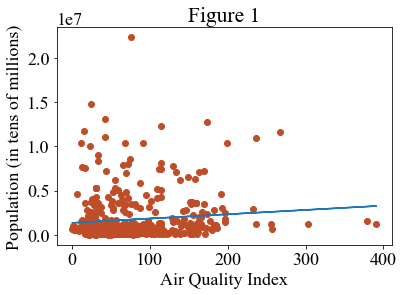

correlation coefficient, p-value: (0.10549200645121772, 0.02014089300197636)
time: 126 ms (started: 2021-12-06 15:11:50 -05:00)


In [65]:
functions.create_figure1(parameter_dict)

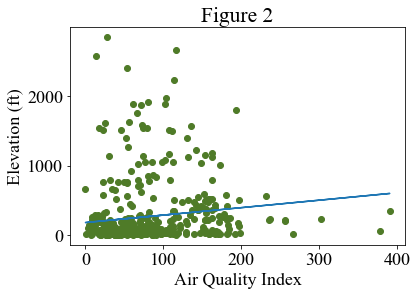

correlation coefficient, p-value: (0.13136811085771335, 0.0037532685213509396)
time: 114 ms (started: 2021-12-06 15:11:51 -05:00)


In [66]:
functions.create_figure2(parameter_dict)

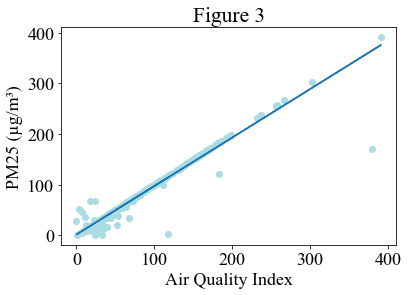

correlation coefficient, p-value: (0.9731060988788065, 4.09030770964454e-310)
time: 115 ms (started: 2021-12-06 15:11:51 -05:00)


In [67]:
functions.create_figure3(parameter_dict)

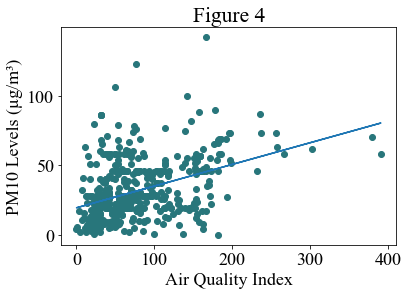

correlation coefficient, p-value: (0.40312097762649624, 2.237812723496048e-20)
time: 103 ms (started: 2021-12-06 15:11:51 -05:00)


In [68]:
functions.create_figure4(parameter_dict)

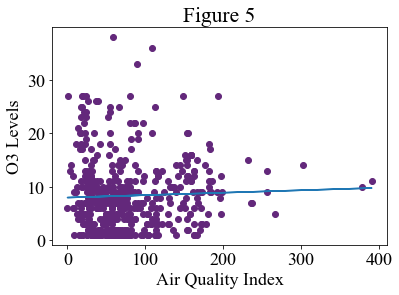

correlation coefficient, p-value: (0.03852017053760951, 0.39730512841052523)
time: 108 ms (started: 2021-12-06 15:11:51 -05:00)


In [69]:
functions.create_figure5(parameter_dict)

## Time Complexity 

The most computationally expensive part of this project was collecting the data from the Air Quality Programmatic API. The code used to collect this data took 37min 58s (as you can see from the autotime module in the WAQI_API.ipynb notebook). 

The second most computationally expensive part of this project is the map visual we created with the Folium package. As we learned this year, graphics data is rich and has to communicate with many parts of the computer to render properly. Especially, if the graphic is in color like ours. The map visual we created with folium takes about 1 second to run.

## Analysis 

Population vs AQI

* The correlation coefficient of the linear relationship between the Air Quality Index and Population for the 489 cities we have data on is 0.105492. The significance of this data is represented by the p-value of this relationship which is 0.0201409.
* Our null hypothesis was that there would no relationship between cities’ Air Quality Index and Population. Our alternative hypothesis was that the correlation coefficient of the linear relationship between the Air Quality Index and Population is greater than or equal to 0.5. With an alpha value of 0.05, we reject our alternative hypothesis because the p-value of 0.0201409 is less than 0.05.

Elevation vs AQI

* The correlation coefficient of the linear relationship between the Air Quality Index and Elevation for the 489 cities we have data on is 0.131368. The significance of this data is represented by the p-value of this relationship which is 0.003753.
* Our null hypothesis was that there would be no relationship between cities’ Air Quality Index and Elevation. Our alternative hypothesis was that the correlation coefficient of the linear relationship between the Air Quality Index and Elevation is greater than or equal to 0.5. With an alpha value of 0.05, we reject our alternative hypothesis because the p-value of 0.003753 is less than 0.05.

PM25 vs AQI

* The correlation coefficient of the linear relationship between the Air Quality Index and the pollutant PM25 for the 489 cities we have data on is 0.973106. The significance of this data is represented by the p-value of this relationship which is 4.090308.
* Our null hypothesis was that there would be no relationship between cities’ Air Quality Index and the pollutant PM25. Our alternative hypothesis was that the correlation coefficient of the linear relationship between the Air Quality Index and the pollutant PM25 is greater than or equal to 0.5. With an alpha value of 0.05, we fail to reject our alternative hypothesis because the p-value of 4.090308 is greater than 0.05.

PM10 vs AQI

* The correlation coefficient of the linear relationship between the Air Quality Index and the pollutant PM10 for the 489 cities we have data on is 0.403121. The significance of this data is represented by the p-value of this relationship which is 2.237813.
* Our null hypothesis was that there would be no relationship between cities’ Air Quality Index and the pollutant PM10. Our alternative hypothesis was that the correlation coefficient of the linear relationship between the Air Quality Index and the pollutant PM10 is greater than or equal to 0.5. With an alpha value of 0.05, we fail to reject our alternative hypothesis because the p-value of 2.237813 is greater than 0.05.



O3 vs AQI

* The correlation coefficient of the linear relationship between the Air Quality Index and the pollutant O3 (ozone) for the 489 cities we have data on is 0.038520. The significance of this data is represented by the p-value of this relationship which is  0.397305.
* Our null hypothesis was that there would be no relationship between cities’ Air Quality Index and the pollutant PM10. Our alternative hypothesis was that the correlation coefficient of the linear relationship between the Air Quality Index and the pollutant O3 is greater than or equal to 0.5. With an alpha value of 0.05, we fail to reject our alternative hypothesis because the p-value of 0.397305 is greater than 0.05.

## Take-aways

The factor that by far had the highest correlation with Air Quality Index was the measure of the PM25 pollutant. The relationship is strong and appears to be significant. Further testing will more thoroughly analyze the significance of the relationship between PM25 levels and Air Quality Index levels. Another route we could take in the future is to gather data from cities other than the 1000 most populated cities in the world. We wonder how the correlations we analyzed would differ from medium-sized cities and small towns.

## References

- Air Quality Programmatic API Documentation: http://aqicn.org/api/
- Spott API Documentation: https://rapidapi.com/Spott/api/spott/
- Folium Documentation: http://python-visualization.github.io/folium/modules.html
- Folium Help Youtube Video: https://www.youtube.com/watch?v=FdqDgoG-SFM
- scipy.stats Documentation: https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
    
    

## Code Guide

- WAQI_API.ipynb
    - In this file, we pull data from the Air Quality Programmatic API and store it in a dataframe.
- Spott_API_to_DF.ipynb
    - In this file, we pull data from the Spott API and store it in a dataframe.
- combined_cleaned_dataframe.ipynb
    - In this file, we cleaned and merged the WAQI and Spott dataframes.
- GEO_Mapping.ipynb
    - In this file, we prepared the merged dataframe for mapping and created an interactive Folium map.
- AQI_Correlations.ipynb
    - In this file, we create the scatterplot visualizations that compare cities' air quality index to their PM25, PM10, and Ozone levels.
- functions.py
    - This file contains all of the functions from our other files needed to present the presentation notebook. 



- waqi_df.csv
    - This is the dataframe in which all the data from the Air Quality Programmatic API is stored. 
- spott_df.csv
    - This is the dataframe in which all the data from the Spott API is stored. 
- combined_df.csv
    - This is the merged dataframe.
    
